# Sanity Check of FedLeak (Resize Generator), Lung & Colon Cancer (LC25000)

Here is the sanity check on if FedLeak has been correctly trasferred.

We evaluate it with ***Lung & Colon Cancer (LC25000)***, with $5$ times sampling batch = $16$, reporting the best results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from train-set, with `shuffle=True`.
- *Way to report*: PSNRs in $5$ times recovery, including the *max* value and the *median* value.

Codes are aligned with `sanity_check_resize_showcase.ipynb`, with `resize_generator.py` introduced.

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, argparse, os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

try:
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from resize_generator import FedLeak
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    os.chdir("..")
    
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from resize_generator import FedLeak


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:2")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128))
])

dataset = torchvision.datasets.ImageFolder(root="~/data/lung_colon_image_set/", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, generator=torch.Generator().manual_seed(seed))
loader_iter = iter(trainloader)

device

device(type='cuda', index=2)

### 🚩 3. Attack for five times

In [3]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

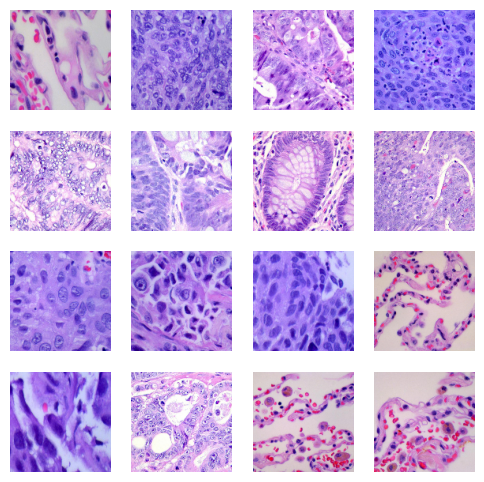

| It: 1 | Loss: -16.7286 | Time:   5.07s |


| It: 1001 | Loss: -61.2250 | Time: 467.22s |


| It: 2001 | Loss: -61.6198 | Time: 467.52s |


| It: 3001 | Loss: -61.7249 | Time: 467.28s |


| It: 4001 | Loss: -61.7843 | Time: 466.99s |


| It: 5001 | Loss: -61.8269 | Time: 466.92s |


| It: 6001 | Loss: -61.8576 | Time: 467.75s |


| It: 7001 | Loss: -61.8820 | Time: 466.41s |


| It: 8001 | Loss: -61.8969 | Time: 466.57s |


| It: 9001 | Loss: -61.9052 | Time: 464.94s |


| It: 1 | Loss: -18.0407 | Time:   0.37s |


| It: 1001 | Loss: -61.1577 | Time: 464.21s |


| It: 2001 | Loss: -61.5680 | Time: 467.01s |


| It: 3001 | Loss: -61.6994 | Time: 465.54s |


| It: 4001 | Loss: -61.7657 | Time: 467.82s |


| It: 5001 | Loss: -61.8095 | Time: 465.25s |


| It: 6001 | Loss: -61.8434 | Time: 466.62s |


| It: 7001 | Loss: -61.8699 | Time: 466.86s |


| It: 8001 | Loss: -61.8869 | Time: 466.27s |


| It: 9001 | Loss: -61.8948 | Time: 465.11s |


| It: 1 | Loss: -25.6456 | Time:   0.37s |


| It: 1001 | Loss: -61.0710 | Time: 462.05s |


| It: 2001 | Loss: -61.5596 | Time: 465.57s |


| It: 3001 | Loss: -61.6882 | Time: 464.24s |


| It: 4001 | Loss: -61.7628 | Time: 464.78s |


| It: 5001 | Loss: -61.8063 | Time: 464.46s |


| It: 6001 | Loss: -61.8463 | Time: 464.26s |


| It: 7001 | Loss: -61.8717 | Time: 466.43s |


| It: 8001 | Loss: -61.8883 | Time: 520.08s |


| It: 9001 | Loss: -61.8962 | Time: 565.14s |


| It: 1 | Loss: -31.7580 | Time:   0.49s |


| It: 1001 | Loss: -61.0854 | Time: 565.11s |


| It: 2001 | Loss: -61.5357 | Time: 565.66s |


| It: 3001 | Loss: -61.6799 | Time: 565.98s |


| It: 4001 | Loss: -61.7530 | Time: 563.83s |


| It: 5001 | Loss: -61.8026 | Time: 564.26s |


| It: 6001 | Loss: -61.8397 | Time: 564.65s |


| It: 7001 | Loss: -61.8664 | Time: 562.99s |


| It: 8001 | Loss: -61.8838 | Time: 564.00s |


| It: 9001 | Loss: -61.8923 | Time: 563.78s |


| It: 1 | Loss: -18.1044 | Time:   0.45s |


| It: 1001 | Loss: -60.8695 | Time: 563.91s |


| It: 2001 | Loss: -61.4180 | Time: 564.28s |


| It: 3001 | Loss: -61.5731 | Time: 562.34s |


| It: 4001 | Loss: -61.6580 | Time: 562.29s |


| It: 5001 | Loss: -61.7159 | Time: 564.18s |


| It: 6001 | Loss: -61.7610 | Time: 560.67s |


| It: 7001 | Loss: -61.7919 | Time: 562.45s |


| It: 8001 | Loss: -61.8145 | Time: 563.22s |


| It: 9001 | Loss: -61.8255 | Time: 563.02s |


BEST PSNR: 14.3667
MEDIAN PSNR: 13.6934
ALL PSNR: [14.3667, 13.8694, 13.2454, 13.4470, 13.4470]


<Figure size 400x300 with 0 Axes>

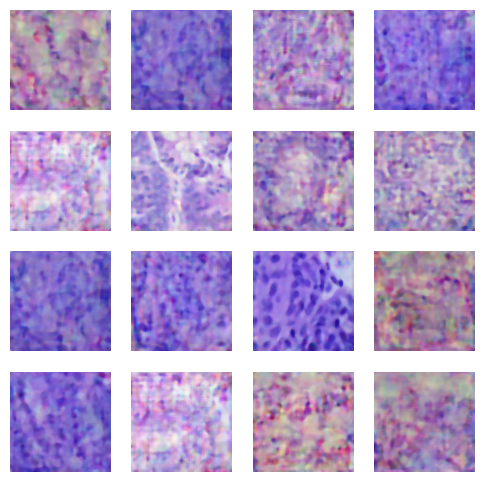

In [4]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

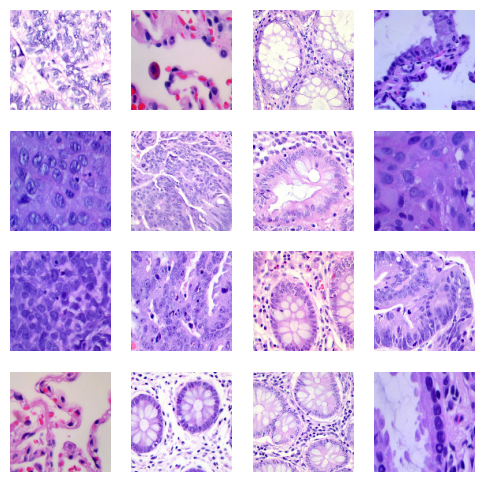

| It: 1 | Loss: -28.8231 | Time:   0.63s |


| It: 1001 | Loss: -60.8608 | Time: 563.37s |


| It: 2001 | Loss: -61.4715 | Time: 561.63s |


| It: 3001 | Loss: -61.6299 | Time: 562.45s |


| It: 4001 | Loss: -61.7144 | Time: 562.07s |


| It: 5001 | Loss: -61.7764 | Time: 565.04s |


| It: 6001 | Loss: -61.8154 | Time: 563.84s |


| It: 7001 | Loss: -61.8486 | Time: 564.33s |


| It: 8001 | Loss: -61.8695 | Time: 563.92s |


| It: 9001 | Loss: -61.8794 | Time: 563.15s |


| It: 1 | Loss: -19.0652 | Time:   0.63s |


| It: 1001 | Loss: -60.8799 | Time: 563.53s |


| It: 2001 | Loss: -61.4480 | Time: 564.25s |


| It: 3001 | Loss: -61.6130 | Time: 564.26s |


| It: 4001 | Loss: -61.6974 | Time: 562.58s |


| It: 5001 | Loss: -61.7583 | Time: 563.25s |


| It: 6001 | Loss: -61.8037 | Time: 562.43s |


| It: 7001 | Loss: -61.8402 | Time: 564.49s |


| It: 8001 | Loss: -61.8599 | Time: 562.40s |


| It: 9001 | Loss: -61.8703 | Time: 562.02s |


| It: 1 | Loss: -17.6933 | Time:   0.60s |


| It: 1001 | Loss: -60.3059 | Time: 560.30s |


| It: 2001 | Loss: -61.2342 | Time: 563.27s |


| It: 3001 | Loss: -61.5363 | Time: 561.65s |


| It: 4001 | Loss: -61.6614 | Time: 564.67s |


| It: 5001 | Loss: -61.7334 | Time: 562.22s |


| It: 6001 | Loss: -61.7887 | Time: 563.26s |


| It: 7001 | Loss: -61.8240 | Time: 562.66s |


| It: 8001 | Loss: -61.8491 | Time: 560.25s |


| It: 9001 | Loss: -61.8619 | Time: 564.44s |


| It: 1 | Loss: -25.9616 | Time:   0.63s |


| It: 1001 | Loss: -60.8274 | Time: 564.58s |


| It: 2001 | Loss: -61.3344 | Time: 562.54s |


| It: 3001 | Loss: -61.5051 | Time: 564.31s |


| It: 4001 | Loss: -61.6235 | Time: 563.21s |


| It: 5001 | Loss: -61.7187 | Time: 561.61s |


| It: 6001 | Loss: -61.7888 | Time: 565.15s |


| It: 7001 | Loss: -61.8350 | Time: 442.02s |


| It: 8001 | Loss: -61.8616 | Time: 353.98s |


| It: 9001 | Loss: -61.8744 | Time: 353.16s |


| It: 1 | Loss: -27.7909 | Time:   0.35s |


| It: 1001 | Loss: -61.0138 | Time: 351.65s |


| It: 2001 | Loss: -61.5001 | Time: 353.10s |


| It: 3001 | Loss: -61.6421 | Time: 354.44s |


| It: 4001 | Loss: -61.7223 | Time: 354.27s |


| It: 5001 | Loss: -61.7729 | Time: 353.88s |


| It: 6001 | Loss: -61.8160 | Time: 354.37s |


| It: 7001 | Loss: -61.8452 | Time: 350.71s |


| It: 8001 | Loss: -61.8657 | Time: 350.22s |


| It: 9001 | Loss: -61.8757 | Time: 354.79s |


BEST PSNR: 13.3455
MEDIAN PSNR: 12.6901
ALL PSNR: [13.3455, 11.8573, 12.3742, 12.5883, 12.5883]


<Figure size 400x300 with 0 Axes>

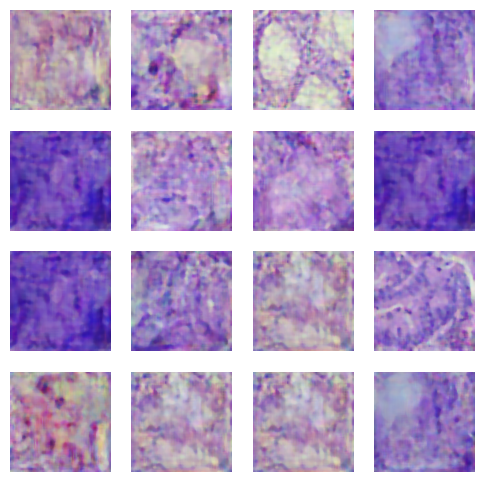

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

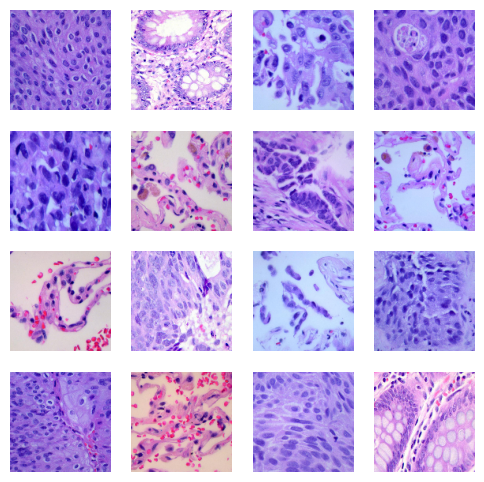

| It: 1 | Loss: -12.1955 | Time:   0.35s |


| It: 1001 | Loss: -60.7633 | Time: 350.75s |


| It: 2001 | Loss: -61.3597 | Time: 354.63s |


| It: 3001 | Loss: -61.5687 | Time: 352.51s |


| It: 4001 | Loss: -61.6618 | Time: 353.15s |


| It: 5001 | Loss: -61.7345 | Time: 350.33s |


| It: 6001 | Loss: -61.7862 | Time: 352.52s |


| It: 7001 | Loss: -61.8285 | Time: 353.31s |


| It: 8001 | Loss: -61.8562 | Time: 352.54s |


| It: 9001 | Loss: -61.8701 | Time: 351.39s |


| It: 1 | Loss: -12.9875 | Time:   0.38s |


| It: 1001 | Loss: -60.7562 | Time: 351.17s |


| It: 2001 | Loss: -61.4754 | Time: 352.93s |


| It: 3001 | Loss: -61.6603 | Time: 352.97s |


| It: 4001 | Loss: -61.7398 | Time: 350.27s |


| It: 5001 | Loss: -61.7920 | Time: 352.26s |


| It: 6001 | Loss: -61.8292 | Time: 353.45s |


| It: 7001 | Loss: -61.8558 | Time: 353.35s |


| It: 8001 | Loss: -61.8733 | Time: 353.74s |


| It: 9001 | Loss: -61.8828 | Time: 355.30s |


| It: 1 | Loss: -15.4189 | Time:   0.38s |


| It: 1001 | Loss: -60.6800 | Time: 350.31s |


| It: 2001 | Loss: -61.3193 | Time: 346.73s |


| It: 3001 | Loss: -61.5052 | Time: 349.31s |


| It: 4001 | Loss: -61.6221 | Time: 353.42s |


| It: 5001 | Loss: -61.6878 | Time: 346.62s |


| It: 6001 | Loss: -61.7459 | Time: 352.00s |


| It: 7001 | Loss: -61.7847 | Time: 348.55s |


| It: 8001 | Loss: -61.8097 | Time: 351.26s |


| It: 9001 | Loss: -61.8228 | Time: 350.22s |


| It: 1 | Loss: -27.5148 | Time:   0.38s |


| It: 1001 | Loss: -60.2209 | Time: 351.28s |


| It: 2001 | Loss: -61.3302 | Time: 351.28s |


| It: 3001 | Loss: -61.5745 | Time: 352.19s |


| It: 4001 | Loss: -61.6914 | Time: 352.12s |


| It: 5001 | Loss: -61.7555 | Time: 352.11s |


| It: 6001 | Loss: -61.8065 | Time: 352.90s |


| It: 7001 | Loss: -61.8399 | Time: 353.55s |


| It: 8001 | Loss: -61.8606 | Time: 351.72s |


| It: 9001 | Loss: -61.8706 | Time: 353.83s |


| It: 1 | Loss: -21.2142 | Time:   0.36s |


| It: 1001 | Loss: -60.6578 | Time: 351.35s |


| It: 2001 | Loss: -61.5217 | Time: 352.04s |


| It: 3001 | Loss: -61.6679 | Time: 350.76s |


| It: 4001 | Loss: -61.7443 | Time: 348.89s |


| It: 5001 | Loss: -61.7965 | Time: 352.56s |


| It: 6001 | Loss: -61.8339 | Time: 353.38s |


| It: 7001 | Loss: -61.8607 | Time: 352.18s |


| It: 8001 | Loss: -61.8781 | Time: 355.94s |


| It: 9001 | Loss: -61.8866 | Time: 359.23s |


BEST PSNR: 14.8128
MEDIAN PSNR: 13.2995
ALL PSNR: [12.6762, 12.5230, 12.2825, 14.2029, 14.2029]


<Figure size 400x300 with 0 Axes>

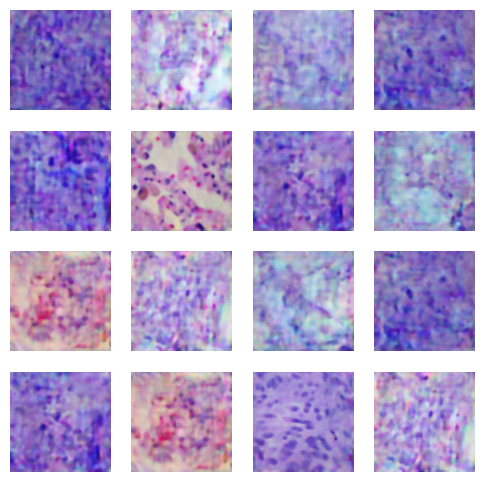

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

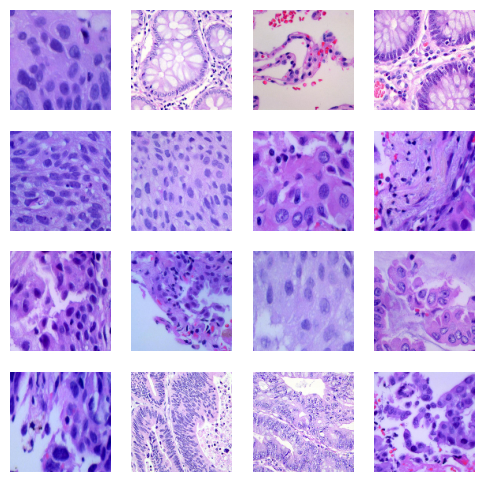

| It: 1 | Loss: -21.3391 | Time:   0.31s |


| It: 1001 | Loss: -61.0289 | Time: 359.27s |


| It: 2001 | Loss: -61.4882 | Time: 361.42s |


| It: 3001 | Loss: -61.6502 | Time: 359.19s |


| It: 4001 | Loss: -61.7468 | Time: 360.74s |


| It: 5001 | Loss: -61.8048 | Time: 358.13s |


| It: 6001 | Loss: -61.8419 | Time: 363.76s |


| It: 7001 | Loss: -61.8727 | Time: 362.91s |


| It: 8001 | Loss: -61.8921 | Time: 364.27s |


| It: 9001 | Loss: -61.9008 | Time: 364.82s |


| It: 1 | Loss: -37.3727 | Time:   0.37s |


| It: 1001 | Loss: -60.9296 | Time: 361.18s |


| It: 2001 | Loss: -61.4858 | Time: 364.17s |


| It: 3001 | Loss: -61.6485 | Time: 364.42s |


| It: 4001 | Loss: -61.7399 | Time: 361.48s |


| It: 5001 | Loss: -61.7952 | Time: 363.33s |


| It: 6001 | Loss: -61.8361 | Time: 365.53s |


| It: 7001 | Loss: -61.8678 | Time: 364.19s |


| It: 8001 | Loss: -61.8859 | Time: 362.26s |


| It: 9001 | Loss: -61.8953 | Time: 362.63s |


| It: 1 | Loss: -4.8798 | Time:   0.39s |


| It: 1001 | Loss: -60.9466 | Time: 364.18s |


| It: 2001 | Loss: -61.4395 | Time: 361.93s |


| It: 3001 | Loss: -61.6283 | Time: 363.06s |


| It: 4001 | Loss: -61.7184 | Time: 364.01s |


| It: 5001 | Loss: -61.7809 | Time: 362.64s |


| It: 6001 | Loss: -61.8258 | Time: 365.11s |


| It: 7001 | Loss: -61.8588 | Time: 363.28s |


| It: 8001 | Loss: -61.8787 | Time: 362.05s |


| It: 9001 | Loss: -61.8884 | Time: 365.13s |


| It: 1 | Loss: -33.1086 | Time:   0.38s |


| It: 1001 | Loss: -60.7488 | Time: 360.33s |


| It: 2001 | Loss: -61.4073 | Time: 359.80s |


| It: 3001 | Loss: -61.6099 | Time: 362.66s |


| It: 4001 | Loss: -61.7097 | Time: 358.79s |


| It: 5001 | Loss: -61.7728 | Time: 360.80s |


| It: 6001 | Loss: -61.8184 | Time: 357.38s |


| It: 7001 | Loss: -61.8549 | Time: 364.46s |


| It: 8001 | Loss: -61.8750 | Time: 362.07s |


| It: 9001 | Loss: -61.8856 | Time: 364.96s |


| It: 1 | Loss: -25.9095 | Time:   0.39s |


| It: 1001 | Loss: -60.6447 | Time: 362.81s |


| It: 2001 | Loss: -61.3489 | Time: 363.21s |


| It: 3001 | Loss: -61.5855 | Time: 361.55s |


| It: 4001 | Loss: -61.6978 | Time: 362.46s |


| It: 5001 | Loss: -61.7639 | Time: 360.78s |


| It: 6001 | Loss: -61.8151 | Time: 362.68s |


| It: 7001 | Loss: -61.8481 | Time: 360.60s |


| It: 8001 | Loss: -61.8712 | Time: 363.35s |


| It: 9001 | Loss: -61.8809 | Time: 363.71s |


BEST PSNR: 14.2682
MEDIAN PSNR: 13.6182
ALL PSNR: [13.2248, 13.1472, 13.3986, 14.0523, 14.0523]


<Figure size 400x300 with 0 Axes>

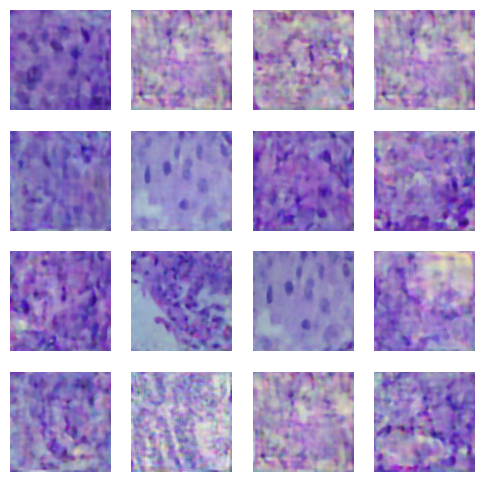

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

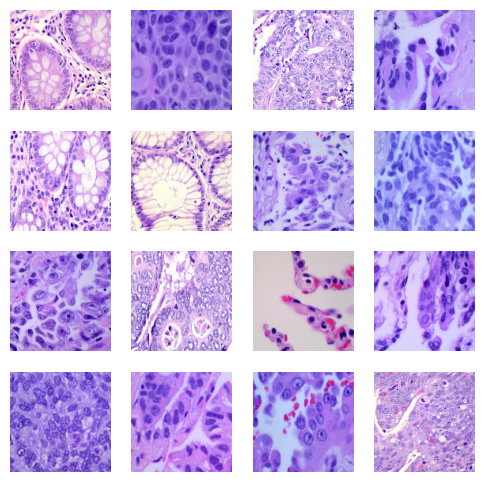

| It: 1 | Loss: -26.7740 | Time:   0.40s |


| It: 1001 | Loss: -61.0145 | Time: 363.14s |


| It: 2001 | Loss: -61.5689 | Time: 363.70s |


| It: 3001 | Loss: -61.7188 | Time: 363.73s |


| It: 4001 | Loss: -61.7830 | Time: 364.02s |


| It: 5001 | Loss: -61.8272 | Time: 363.03s |


| It: 6001 | Loss: -61.8593 | Time: 361.91s |


| It: 7001 | Loss: -61.8805 | Time: 363.75s |


| It: 8001 | Loss: -61.8947 | Time: 368.14s |


| It: 9001 | Loss: -61.9018 | Time: 364.28s |


| It: 1 | Loss: -27.0833 | Time:   0.39s |


| It: 1001 | Loss: -61.1817 | Time: 363.99s |


| It: 2001 | Loss: -61.6419 | Time: 361.83s |


| It: 3001 | Loss: -61.7385 | Time: 364.07s |


| It: 4001 | Loss: -61.8008 | Time: 364.56s |


| It: 5001 | Loss: -61.8412 | Time: 362.47s |


| It: 6001 | Loss: -61.8684 | Time: 362.78s |


| It: 7001 | Loss: -61.8888 | Time: 363.22s |


| It: 8001 | Loss: -61.9032 | Time: 363.03s |


| It: 9001 | Loss: -61.9105 | Time: 361.86s |


| It: 1 | Loss: -19.8841 | Time:   0.40s |


| It: 1001 | Loss: -61.2613 | Time: 361.59s |


| It: 2001 | Loss: -61.6808 | Time: 362.00s |


| It: 3001 | Loss: -61.7751 | Time: 353.94s |


| It: 4001 | Loss: -61.8252 | Time: 359.03s |


| It: 5001 | Loss: -61.8560 | Time: 362.45s |


| It: 6001 | Loss: -61.8801 | Time: 355.03s |


| It: 7001 | Loss: -61.8980 | Time: 362.27s |


| It: 8001 | Loss: -61.9111 | Time: 363.79s |


| It: 9001 | Loss: -61.9168 | Time: 364.50s |


| It: 1 | Loss: -28.9932 | Time:   0.40s |


| It: 1001 | Loss: -61.3770 | Time: 364.34s |


| It: 2001 | Loss: -61.6826 | Time: 363.02s |


| It: 3001 | Loss: -61.7688 | Time: 363.76s |


| It: 4001 | Loss: -61.8158 | Time: 360.52s |


| It: 5001 | Loss: -61.8473 | Time: 365.41s |


| It: 6001 | Loss: -61.8754 | Time: 365.66s |


| It: 7001 | Loss: -61.8949 | Time: 361.00s |


| It: 8001 | Loss: -61.9068 | Time: 362.76s |


| It: 9001 | Loss: -61.9128 | Time: 363.52s |


| It: 1 | Loss: -21.3509 | Time:   0.38s |


| It: 1001 | Loss: -61.2540 | Time: 361.73s |


| It: 2001 | Loss: -61.6413 | Time: 358.20s |


| It: 3001 | Loss: -61.7419 | Time: 360.69s |


| It: 4001 | Loss: -61.7989 | Time: 362.89s |


| It: 5001 | Loss: -61.8370 | Time: 367.84s |


| It: 6001 | Loss: -61.8652 | Time: 366.77s |


| It: 7001 | Loss: -61.8857 | Time: 364.21s |


| It: 8001 | Loss: -61.8998 | Time: 366.03s |


| It: 9001 | Loss: -61.9068 | Time: 365.28s |


BEST PSNR: 14.8998
MEDIAN PSNR: 13.7461
ALL PSNR: [13.8494, 12.3296, 14.7132, 12.9386, 12.9386]


<Figure size 400x300 with 0 Axes>

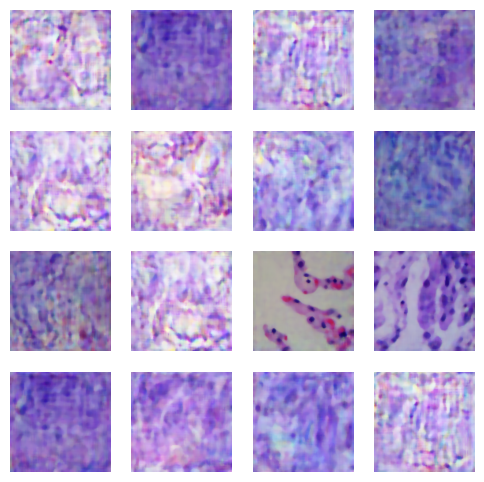

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)